### Import of libraries we are going to use

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.datasets import load_iris


### Import of csv data

In [2]:
hashed_df = pd.read_csv('hashed_data.csv')
tabular_df = pd.read_csv('tabular_data.csv')
train_df = pd.read_csv('train_target.csv')
test_df = pd.read_csv('test_target.csv')
tabular_df.head(5)

,PERIOD,ID,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,...,V_34,V_35,V_36,V_37,V_38,V_39,V_40,V_41,V_42,V_43
0,1,1,27.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,NaN,0.0,0.0,45.53,1.0550,0.0,0.0,45.53,0.0,0.0
1,2,1,19.0,0.0,NaN,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,48.00,NaN,NaN,0.0,48.00,0.0,0.0
2,3,1,22.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,46.59,0.0000,0.0,0.0,46.59,0.0,0.0
3,1,2,NaN,NaN,0.0,1.0,1.0,NaN,0.0,NaN,...,9.0,0.0,0.0,157.50,3.3075,0.0,0.0,157.50,0.0,0.0
4,2,2,28.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,NaN,0.0,0.0,157.50,3.6400,0.0,0.0,157.50,0.0,0.0


### Simple way to remove NaN values, proly too simple ...
#### My though process: 
Since we were not given details about meaning of the colums, it can be assumed that colums with ones and zeroes are some kind of categorical data. So it would be better to replace NaNs on on those columns with lets say 2, so it can have some meaning. Then, when those NaN gaps are filled we can start cleaning other NaN datapoints. I believe it will be more optimal (compared to just <b><i>fillna bfill </i></b> method) to build a linear regression model based on other existing data and make predictions of this values based on that model. But here its done with the simplest solution.

In [3]:
tabular_df = tabular_df.fillna(axis='columns', method='bfill')    

### Apply PCA to group table on PERIODs to reduce dimensionality

In [4]:
## tabular_df_groupped = tabular_df.groupby('ID').agg(lambda x: list(x))
## tabular_df_groupped.head(3)

In [5]:
#X = tabular_df_groupped.iloc[1]
#pca = PCA(n_components=1).fit(X)
#X_pca = pca.transform(X)

### Pivot table to remove PERIODs as rows

In [6]:
tabular_df.head()

,PERIOD,ID,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,...,V_34,V_35,V_36,V_37,V_38,V_39,V_40,V_41,V_42,V_43
0,1.0,1.0,27.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.00,45.53,1.0550,0.0,0.0,45.53,0.0,0.0
1,2.0,1.0,19.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.00,48.00,0.0000,0.0,0.0,48.00,0.0,0.0
2,3.0,1.0,22.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,46.59,46.59,0.0000,0.0,0.0,46.59,0.0,0.0
3,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,9.0,0.0,0.00,157.50,3.3075,0.0,0.0,157.50,0.0,0.0
4,2.0,2.0,28.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.00,157.50,3.6400,0.0,0.0,157.50,0.0,0.0


In [7]:
tabular_df_round = tabular_df.astype({'PERIOD': int, 'ID': int}).astype({'PERIOD': str})

In [8]:
#tabular_df_round.iloc[:, 2].name
#for col_index in (tabular_df_round.shape[1]):
#    print('Column name is: ', tabular_df_round.iloc[:, col_index].name)

In [9]:
column_names_list = []
for column in tabular_df_round.columns[2:]:
    column_names_list.append(column)

In [10]:
# feature columns are sorted the wrong way - 1 2 3 ... 8 9 are in the end (after 41 42 43), but that shouldn't matter
tabular_df_pivoted = pd.pivot_table(tabular_df_round, index=['ID'], columns=['PERIOD'], values=column_names_list)
tabular_df_pivoted = tabular_df_pivoted.reset_index()


In [11]:
tabular_df_pivoted.head(3)

ID   V_1              V_10              V_11              ...  V_6  \
PERIOD        1     2     3     1     2     3     1     2     3  ...    3   
0       1  27.0  19.0  22.0  27.0  19.0  22.0   2.0   2.0   1.0  ...  0.0   
1       2   0.0  28.0  27.0   4.0  28.0  26.0   4.0   8.0   7.0  ...  0.0   
2       3  26.0  26.0  28.0  26.0  26.0  28.0  15.0  11.0  13.0  ...  0.0   

        V_7            V_8             V_9             
PERIOD    1    2    3    1    2    3     1     2    3  
0       0.0  1.0  0.0  0.0  0.0  0.0  27.0  19.0  0.0  
1       0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  
2       1.0  1.0  1.0  1.0  1.0  1.0   0.0   1.0  0.0  

[3 rows x 130 columns]

In [12]:
# join/stack/merge column levels and set readable names for them
tab_df_piv_joined_col_names = tabular_df_pivoted
tab_df_piv_joined_col_names.columns = ['_per_'.join((j,k)) for j,k in tab_df_piv_joined_col_names.columns]

#rename ID column
tab_df_piv_joined_col_names = tab_df_piv_joined_col_names.rename(columns={'ID_per_': 'ID'})


In [13]:
tab_df_piv_joined_col_names.head(3)
tabular_df_all = tab_df_piv_joined_col_names

### Find mean values of three PERIODs based on ID

In [14]:
tabular_df_means = tabular_df.groupby([tabular_df['ID']]).mean()
tabular_df_means.reset_index(level=0, inplace=True)

### Building models

In [17]:
df_train = pd.merge(tabular_df_means, train_df, on='ID')

# split train into train/test to test our model (coz we don't have correct answer in our test dataset - its empty and supposed to filled by us and sent for review)
df_train, df_test = train_test_split(df_train, test_size=0.1) 

y = df_train.TARGET
X = df_train.drop(['PERIOD', 'ID', 'TARGET'], axis=1).fillna(method='bfill')

model = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial').fit(X, y)
print('Logistic Regr Means Score: ', model.score(X, y))

# same thing, but for columns with all periods
df_train_all = pd.merge(tabular_df_all, train_df, on='ID')

df_train_all, df_test_all = train_test_split(df_train_all, test_size=0.1)

y_all = df_train_all.TARGET
X_all = df_train_all.drop(['ID', 'TARGET'], axis=1).fillna(method='bfill')

model_all = LogisticRegression(random_state=0, solver='newton-cg', multi_class='multinomial').fit(X_all, y_all)
print('Logistic Regr All-periods Score: ', model_all.score(X_all, y_all))

Logistic Regr Means Score:  0.7200689061154177
Logistic Regr All-periods Score:  0.7364341085271318


In [18]:
df_test_all.head(4)

,ID,V_1_per_1,V_1_per_2,V_1_per_3,V_10_per_1,V_10_per_2,V_10_per_3,V_11_per_1,V_11_per_2,V_11_per_3,...,V_7_per_1,V_7_per_2,V_7_per_3,V_8_per_1,V_8_per_2,V_8_per_3,V_9_per_1,V_9_per_2,V_9_per_3,TARGET
2844,2845,27.0,24.0,27.0,4.0,24.0,27.0,4.0,9.00,10.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,27.0,1
2552,2553,28.0,29.0,31.0,18.0,23.0,26.0,23.0,27.00,28.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1291,1292,24.0,21.0,24.0,24.0,21.0,24.0,0.0,87.65,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3162,3163,30.0,3.0,31.0,30.0,2.0,31.0,3.0,2.00,3.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1


In [19]:
# prediction for means of periods

X_pred = df_test.drop(['PERIOD', 'ID', 'TARGET'], axis=1).fillna(method='bfill')

res = model.predict_proba(X_pred)[:,1]

# predictions for all periods included

X_pred_all = df_test_all.drop(['ID', 'TARGET'], axis=1).fillna(method='bfill')

res_all = model_all.predict_proba(X_pred_all)[:,1]

In [20]:
# calc ROC AUC score for Logistic Regression (means of periods)
y_true = df_test['TARGET']
y_scores = res
print(f'ROC AUC score for logistic regression (means): {roc_auc_score(y_true, y_scores)}')

# calc ROC AUC score for Logistic Regression (all periods included)
y_true_all = df_test_all['TARGET']
y_scores_all = res_all

print(f'ROC AUC score for logistic regression (all periods): {roc_auc_score(y_true_all, y_scores_all)}')

ROC AUC score for logistic regression (means): 0.6699116820553994
ROC AUC score for logistic regression (all periods): 0.5882196427977516


In [28]:
# SVM classifier (means of periods)
X_svm = df_train.drop(['PERIOD', 'ID', 'TARGET'], axis=1).fillna(method='bfill')
y_svm = df_train.TARGET
model_SVC = SVC(kernel = 'rbf', random_state = 3).fit(X_svm, y_svm)

y_pred_svm = model_SVC.decision_function(X_pred)

# SVM classifier (all periods)
X_svm_all = df_train_all.drop(['ID', 'TARGET'], axis=1).fillna(method='bfill')
y_svm_all = df_train_all.TARGET
model_SVC_all = SVC(kernel = 'rbf', random_state = 3).fit(X_svm_all, y_svm_all)

y_pred_svm_all = model_SVC_all.decision_function(X_pred_all)

In [29]:
# Calc ROC and AUC for Logistic Regr (means of periods)
logistic_fpr, logistic_tpr, threshold = roc_curve(y_true, y_scores)
auc_logistic = auc(logistic_fpr, logistic_tpr)

# Calc ROC and AUC for Logistic Regr (all periods used/stacked)
logistic_fpr_all, logistic_tpr_all, threshold_all = roc_curve(y_true_all, y_scores_all)
auc_logistic_all = auc(logistic_fpr_all, logistic_tpr_all)


# Calc ROC and AUC for SVM (means of periods)
svm_fpr, svm_tpr, threshold_svm = roc_curve(y_true, y_pred_svm)
auc_svm = auc(svm_fpr, svm_tpr)

# Calc ROC and AUC for SVM (all periods used/stacked)
svm_fpr_all, svm_tpr_all, threshold_svm_all = roc_curve(y_true_all, y_pred_svm_all)
auc_svm_all = auc(svm_fpr_all, svm_tpr_all)

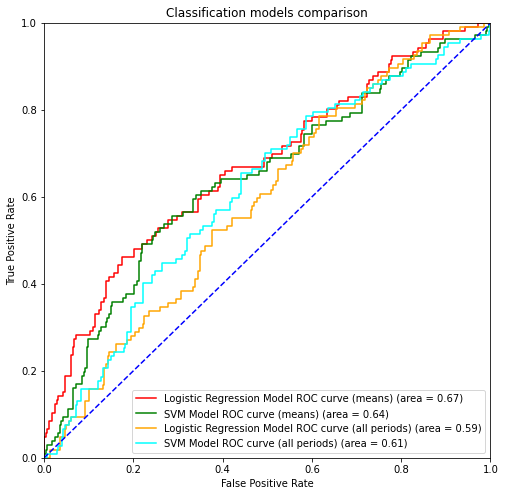

In [30]:
plt.figure(figsize=(8, 8))
plt.plot(logistic_fpr, logistic_tpr, color='red', label='Logistic Regression Model ROC curve (means) (area = %0.2f)' % auc_logistic)
plt.plot(svm_fpr, svm_tpr, color='green', label='SVM Model ROC curve (means) (area = %0.2f)' % auc_svm)

plt.plot(logistic_fpr_all, logistic_tpr_all,color='orange', label='Logistic Regression Model ROC curve (all periods) (area = %0.2f)' % auc_logistic_all)
plt.plot(svm_fpr_all, svm_tpr_all,color='cyan', label='SVM Model ROC curve (all periods) (area = %0.2f)' % auc_svm_all)

plt.plot([0, 1], [0, 1], linestyle='dashed', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification models comparison')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.show()

In [22]:
#test_df.to_csv('HaidaTarasMonkaS_test.txt', sep=',', index=False)